# Titanic - Kaggle Competition: A trial run w Bayes

## Overview
This is an initial run through a Kaggle competition using a well known data set - passenger information from the Titanic and who survived.

The objective is to use machine learning to predict who would survive as a way of getting comfortable with how to submit entries to Kaggle.

### Data Dictionary

Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes 

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


### Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.



## Load and prep the data

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
%matplotlib inline

# signoid function, set as global lambda expression for use throughout
sig = lambda x: 1./(1+np.exp(-x))

In [2]:
# load the data
train= pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# Save 'Survived' column into Y_train
Y_train = train['Survived']

In [5]:
# merge data sets for transformations, now that survived stripped out
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

### Take a quick look at what we have
The first thing we will do is take a look at the data types and how much data is missing (null data) from each column.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
# looking at the signficant missing data (age and cabin),
# an approach to impute the values will need to be explored.

data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
# Cabin data is missing for 77% of the data
# leave this off the table for now, as no real measure to impute any useful information
# possibly use other data sources to fill in gaps
1014/1309.

0.774637127578304

## Feature Engineering: Break down names by title

In [9]:
# dictionary to classify titles into major categories
titles = {  'Capt':        'Professional',
            'Col':         'Professional',
            'Major':       'Professional',
            'Jonkheer':    'Royal',
            'Don':         'Royal',
            'Sir' :        'Royal',
            'Dr':          'Professional',
            'Rev':         'Professional',
            'the Countess':'Royal',
            'Dona':        'Royal',
            'Mme':         'Mrs',
            'Mlle':        'Miss',
            'Ms':          'Mrs',
            'Mr' :         'Mr',
            'Mrs' :        'Mrs',
            'Miss' :       'Miss',
            'Master' :     'Master',
            'Lady' :       'Royal'
            }

# Title is between first comman and next period (e.g. , Mr. )
data['Title'] = data['Name'].map(lambda name:name.split(',')[1]\
                                 .split('.')[0].strip()).map(titles)
    

In [10]:
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royal', 'Professional'], dtype=object)

In [11]:
# look at median age by gender, class and title
ages = data.groupby(['Sex','Pclass','Title'])
ages.median()

Age      Fare  Parch  PassengerId  SibSp  \
Sex    Pclass Title                                                     
female 1      Miss          30.0   99.9625    0.0        529.5    0.0   
              Mrs           45.0   78.1125    0.0        853.5    1.0   
              Professional  49.0   25.9292    0.0        797.0    0.0   
              Royal         39.0   86.5000    0.0        760.0    0.0   
       2      Miss          20.0   20.2500    0.0        606.5    0.0   
              Mrs           30.0   26.0000    0.0        533.0    1.0   
       3      Miss          18.0    8.0500    0.0        603.5    0.0   
              Mrs           31.0   15.5000    1.0        668.5    1.0   
male   1      Master         6.0  134.5000    2.0        803.0    1.0   
              Mr            41.5   47.1000    0.0        634.0    0.0   
              Professional  52.0   37.5500    0.0        678.0    0.0   
              Royal         40.0   27.7208    0.0        600.0    0.0   
       2      Master         2.0   26.0000    1.0        550.0    1.0   
              Mr            30.0   13.0000    0.0        723.5    0.0   
              Professional  41.5   13.0000    0.0        513.0    0.0   
       3      Master         6.0   22.3583    1.0        789.0    3.0   
              Mr            26.0    7.8958    0.0        640.5    0.0   

                            Survived  
Sex    Pclass Title                   
female 1      Miss               1.0  
              Mrs                1.0  
              Professional       1.0  
              Royal              1.0  
       2      Miss               1.0  
              Mrs                1.0  
       3      Miss               0.5  
              Mrs                0.5  
male   1      Master             1.0  
              Mr                 0.0  
              Professional       0.0  
              Royal              0.0  
       2      Master             1.0  
              Mr                 0.0  
              Professional       0.0  
       3      Master             0.0  
              Mr                 0.0

In [12]:
# impute missing ages by groupong by gender, class and title
data['Age'] = data.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x:
                                                                x.fillna(x.median()))


In [13]:
# with Age imputed, leave cabin as is for now
data.isnull().sum()

Age               0
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Title             0
dtype: int64

## Feature Engineering: Categorize by Family Size

In [14]:
data['Family'] = data['Parch'] + data['SibSp'] + 1

In [15]:
# numbers don't sum completey because the passenger list is not complete
data['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [16]:
data['Family_cat'] = data['Family'].map(lambda s :
                                    'alone' if s == 1 else 'small' if s < 5 else 'large')

In [17]:
data['Family_cat'].value_counts()

alone    790
small    437
large     82
Name: Family_cat, dtype: int64

## A look at major categories survival rate

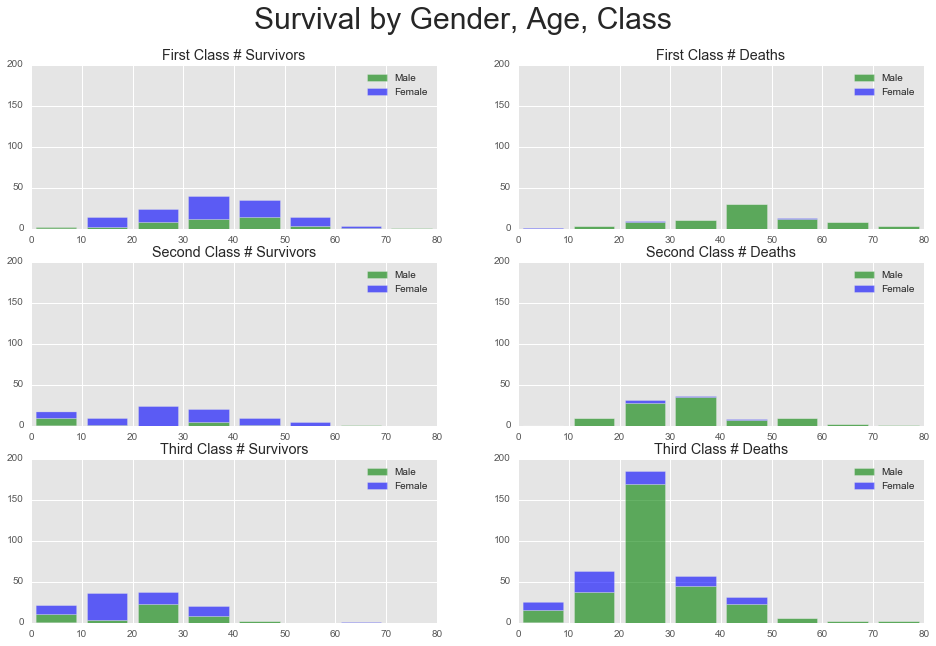

In [18]:
fig, ax2 = plt.subplots(3,2, figsize=(16,10))
category = 'Survival by Gender, Age, Class'

# set bin sizes to b the same
binBoundaries = np.linspace(0,80,9)

def details(j):
    if j == 0:
        pclass = 'First'
    elif j == 1:
        pclass = 'Second'
    else:
        pclass = 'Third'
    # sets titles for each subplot
    ax2[j][0].set_title('{0} Class # Survivors'.format(pclass))
    ax2[j][1].set_title('{0} Class # Deaths'.format(pclass)) 
    # sets common scale on all charts
    ax2[j][0].set_ylim(0,200)
    ax2[j][1].set_ylim(0,200)
    # turn on legends
    ax2[i][0].legend()
    ax2[j][1].legend()

for i in range(0,3):
    # survivors
    ax2[i][0].hist([data[(data['Survived']==1)&(data['Pclass']==i+1)&
                            (data['Sex']=='male')]['Age'], data[(data['Survived']==1)&
                            (data['Pclass']==i+1)&(data['Sex']=='female')]['Age']],
                             stacked=True, color = ['g','b'], bins = binBoundaries,
                             label = ['Male','Female'], alpha = 0.6)   
    # deaths
    ax2[i][1].hist([data[(data['Survived']==0)&(data['Pclass']==i+1)&
                            (data['Sex']=='male')]['Age'], data[(data['Survived']==0)&
                            (data['Pclass']==i+1)&(data['Sex']=='female')]['Age']],
                             stacked=True, color = ['g','b'], bins = binBoundaries,
                             label = ['Male','Female'], alpha = 0.6)
    # set graph lables/titles, etc
    details(i)

# font size for main title
fig.suptitle(category, fontsize=30);

## Feature Engineering: Creating Age Brackets/Buckets

In [19]:
data['Age_cat'] = data['Age'].map(lambda a: '0-5' if a < 6 else '6-15' if a <16 else '16-25'
                                    if a < 26 else '26-35' if a <36 else '36-45' if a < 46
                                    else '46+')

In [20]:
data['Age_cat'].value_counts()

26-35    449
16-25    377
36-45    206
46+      154
6-15      67
0-5       56
Name: Age_cat, dtype: int64

### Ticket Data
Let's take a look at the ticket data to see how we may be able to use it.

In [21]:
data['Ticket'].value_counts()

CA. 2343         11
CA 2144           8
1601              8
S.O.C. 14879      7
PC 17608          7
347077            7
347082            7
3101295           7
347088            6
113781            6
382652            6
19950             6
16966             5
PC 17757          5
W./C. 6608        5
349909            5
113503            5
220845            5
4133              5
PC 17760          4
PC 17755          4
24160             4
LINE              4
17421             4
230136            4
12749             4
SC/Paris 2123     4
113760            4
36928             4
C.A. 34651        4
                 ..
C.A. 24579        1
347062            1
323951            1
233478            1
315088            1
248723            1
347079            1
248726            1
347074            1
347075            1
347076            1
C.A. 18723        1
250652            1
347073            1
330935            1
248659            1
330932            1
330931            1
233866            1


In [22]:
data['Ticket_num'] =\
    data['Ticket'].apply(lambda x: pd.Series(x.split()[-1]))
data['tick_len'] = data['Ticket_num'].apply(lambda x: pd.Series(len(x)))

In [23]:
data.describe()

/Users/alex/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family,tick_len
count,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000,1309.000000
mean,29.278205,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838,1.883881,5.332315
std,13.446690,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592,1.583639,0.902953
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,21.000000,NaN,0.000000,328.000000,2.000000,0.000000,NaN,1.000000,5.000000
50%,26.000000,NaN,0.000000,655.000000,3.000000,0.000000,NaN,1.000000,6.000000
75%,36.500000,NaN,0.000000,982.000000,3.000000,1.000000,NaN,2.000000,6.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000,11.000000,7.000000


## Use Seaborn pairplot to get a quick view of relationships

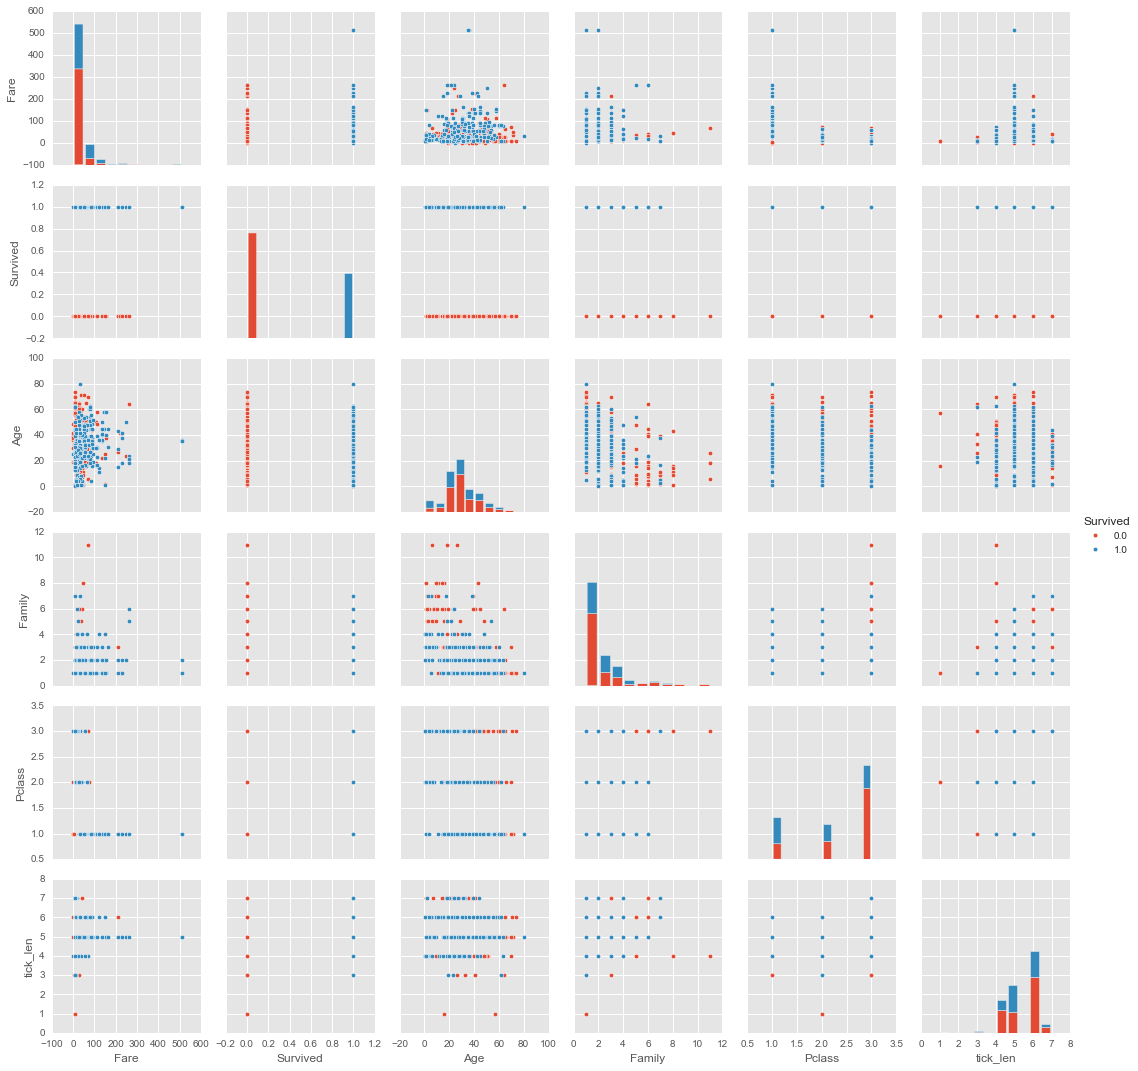

In [24]:
sns.pairplot(data=data[['Fare','Survived','Age','Sex','Family','Pclass','tick_len']],
             hue='Survived');

In [25]:
# 15 zero fares, is this correct, or shoudl they be imputed?
# looking at Titanic data, some passengers did not pay a fair, either comped or company
# sponsored, so difficult to call how to treat this
data[data['Fare']==0.0]['Fare'].value_counts()

0.0    17
Name: Fare, dtype: int64

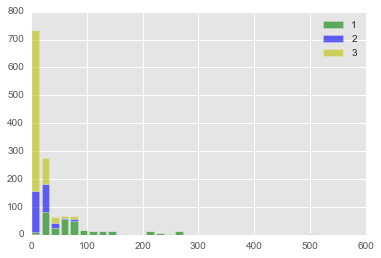

In [26]:
# Look at distribution of ticket prices

plt.hist([data[data['Pclass']==1]['Fare'],
         data[data['Pclass']==2]['Fare'],
         data[data['Pclass']==3]['Fare']],
         stacked=True, color = ['g','b','y'], bins = 30,
         label = ['1','2','3'], alpha = 0.6)

plt.legend();

## Feature Engineering: Ticket Price Buckets

In [27]:
data['Fare_cat'] = data['Fare'].map(lambda f: '0-20' if f < 21 else '21-40' if f <41
                                      else '41-60' if f < 61 else '61-80' if f <81
                                      else '81-100' if f < 101 else '101+')

In [28]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family,Family_cat,Age_cat,Ticket_num,tick_len,Fare_cat
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,2,small,16-25,21171,5,0-20
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,2,small,36-45,17599,5,61-80
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,1,alone,26-35,3101282,7,0-20
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,2,small,26-35,113803,6,41-60
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,1,alone,26-35,373450,6,0-20


## Columns to remove in prep for Classificaiton Model

* Passenger ID
* Name - we have extracted title
* Age - we have put Age into categores 'Age_cat'
* Ticket - have created 'tick_len'
* Fare - have created 'Fare_cat'
* Cabin - too much missing data
* Family - have put into larger buckets in 'Family_cat'
* Ticket_num - used to create 'tick_len'

In [29]:
data.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family,Family_cat,Age_cat,Ticket_num,tick_len,Fare_cat
1304,26.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,Mr,1,alone,26-35,3236,4,0-20
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,Royal,1,alone,36-45,17758,5,101+
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,Mr,1,alone,36-45,3101262,7,0-20
1307,26.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Mr,1,alone,26-35,359309,6,0-20
1308,6.0,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,Master,3,small,6-15,2668,4,21-40


In [30]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
# change numbers to strings before get_dummies

to_num_str = ['Pclass','SibSp','Parch','tick_len']

for s in to_num_str:
    data[s] = data[s].apply(str)

In [32]:
Y_train = train['Survived']

In [33]:
len(Y_train)

891

In [34]:
data = data.drop(['PassengerId','Name','Age','Ticket','Fare','Cabin','Family','Ticket_num',
                  'Survived'],1)

In [35]:
data.head()

,Embarked,Parch,Pclass,Sex,SibSp,Title,Family_cat,Age_cat,tick_len,Fare_cat
0,S,0,3,male,1,Mr,small,16-25,5,0-20
1,C,0,1,female,1,Mrs,small,36-45,5,61-80
2,S,0,3,female,0,Miss,alone,26-35,7,0-20
3,S,0,1,female,1,Mrs,small,26-35,6,41-60
4,S,0,3,male,0,Mr,alone,26-35,6,0-20


In [36]:
data = pd.get_dummies(data)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 50 columns):
Embarked_C            1309 non-null float64
Embarked_Q            1309 non-null float64
Embarked_S            1309 non-null float64
Parch_0               1309 non-null float64
Parch_1               1309 non-null float64
Parch_2               1309 non-null float64
Parch_3               1309 non-null float64
Parch_4               1309 non-null float64
Parch_5               1309 non-null float64
Parch_6               1309 non-null float64
Parch_9               1309 non-null float64
Pclass_1              1309 non-null float64
Pclass_2              1309 non-null float64
Pclass_3              1309 non-null float64
Sex_female            1309 non-null float64
Sex_male              1309 non-null float64
SibSp_0               1309 non-null float64
SibSp_1               1309 non-null float64
SibSp_2               1309 non-null float64
SibSp_3               1309 non-null float64
SibSp_4      

In [38]:
# drop one column from each set of dummy variables
data = data.drop(['Pclass_1','Sex_male','SibSp_8','Parch_6','Embarked_S',
                        'Title_Royal','Family_cat_large','Age_cat_46+','tick_len_1',
                        'Fare_cat_101+'],1)

In [39]:
# Slice data back into train/test
# Y_train data already removed from data df

X_train = data.ix[0:890]
X_test = data.ix[891:]

In [40]:
X_train.shape

(891, 40)

In [41]:
X_test.shape

(418, 40)

In [42]:
# Set up data with survived as first column
train = X_train
train.insert(0, 'Survived', Y_train)


In [43]:
train.head()

,Survived,Embarked_C,Embarked_Q,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_9,...,tick_len_3,tick_len_4,tick_len_5,tick_len_6,tick_len_7,Fare_cat_0-20,Fare_cat_21-40,Fare_cat_41-60,Fare_cat_61-80,Fare_cat_81-100
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [44]:
train_list = train.values.tolist()

Add Survived as first column - to correspond to index[0]



# Bayesian Approach

## The Distribution Model

The model contains 41 parameters as a type of logistic regression, so the model is set up as follows:

### Likelihood

$$g(x) =\omega_0 + \omega_1param_1 + \omega_2param_2 + ... \omega_{41} param_{41}$$ 

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

$$p = \sigma(g) = \frac{1}{1+e^{-g}}$$

So the pdf of the likelihood becomes: 
$$log(\sigma(g)) = -log({1+e^{-g}})$$

### Prior

For the Prior $\pi$ we chose the following over $\omega_0,\omega_1, \omega_2, \omega_3, ..., \omega_{40}$:

$$ \pi(\omega) = \frac{1}{2 \pi} e^{-\frac{1}{2}\omega_0^2}e^{-\frac{1}{2}\omega_1^2} e^{-\frac{1}{2}\omega_2^2} ... e^{-\frac{1}{2}\omega_{41}^2} $$

the log prior is:

$$ =  -\frac{1}{2}(\omega_0^2 + \omega_1^2+ \omega_2^2 +...+ \omega_{41}^2) $$


### Constraints

1. if status == 1 then return P
2. if status == 0 then return 1-P


In [45]:
sigmoid = lambda g: 1./(1+np.exp(-g))

def log_predictive(w,dd):
    g = w[0] + np.sum([w[i]*dd[i] for i in range(1,40)])
    if dd[0] == 1:
        return np.log(sigmoid(g))
    else:
        return np.log(1 - sigmoid(g))

def log_prior(w):
    return -0.5 * np.sum([i**2 for i in w]) 

def lnprob(w):
    return log_prior(w) + np.sum([log_predictive(w,d) for d in train_list])

In [46]:
import emcee
import corner


In [47]:
import timeit
start_time = timeit.default_timer() # to time how long code takes to run


# Run MCMC 

steps = 20000 # number of steps

nwalkers = 100
ndim = 41 # reduced by two variables (remove 1 each from sets of dummy variables)
p0 = np.random.rand(nwalkers*ndim).reshape((nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads = 75)
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, steps)
samples = sampler.flatchain

elapsed = timeit.default_timer() - start_time 

print('Elapsed time for MCMCM run: {0}'.format(elapsed))


Elapsed time for MCMCM run: 17606.772404


In [48]:

MC_samples = pd.DataFrame(samples)
MC_samples.to_csv('MC_samples.csv')

In [70]:
X_test.to_csv('Prepped_test_data.csv')

2m steps (20,000 steps by 100 walkers) took 4.9 hours on 75 threads - 3-4 processors

In [53]:
MC_samples.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,-1.021660e+00,4.015596e-01,3.005784e-01,4.564214e-02,-1.739459e-01,-1.140300e-01,5.697002e-01,-7.140974e-01,-4.464944e-01,-1.472388e-01,...,4.699496e-01,-3.289249e-01,1.138317e-01,-4.602218e-01,4.085285e-01,-5.136847e-01,-2.966859e-01,4.141188e-01,-3.447622e-01,5.432491e-02
std,7.472920e-01,3.273874e-01,3.410785e-01,5.452845e-01,5.331106e-01,5.658948e-01,8.662091e-01,9.258720e-01,9.958458e-01,1.037316e+00,...,7.584942e-01,5.035736e-01,4.731803e-01,4.725353e-01,5.827219e-01,4.812141e-01,4.006311e-01,4.713091e-01,4.852904e-01,1.007800e+00
min,-4.044378e+00,-8.783117e-01,-1.413826e+00,-2.299953e+00,-2.719265e+00,-2.552776e+00,-2.857220e+00,-5.582264e+00,-5.015430e+00,-4.476076e+00,...,-2.956656e+00,-2.846745e+00,-2.032260e+00,-2.582332e+00,-2.104896e+00,-2.573847e+00,-1.967893e+00,-1.770875e+00,-2.682482e+00,-4.348358e+00
25%,-1.534673e+00,1.796408e-01,6.938693e-02,-3.191812e-01,-5.338100e-01,-4.935161e-01,-2.652317e-02,-1.321052e+00,-1.034321e+00,-8.326701e-01,...,-3.647163e-02,-6.625536e-01,-2.086597e-01,-7.826486e-01,1.432732e-02,-8.393610e-01,-5.638508e-01,9.566712e-02,-6.741543e-01,-6.261466e-01
50%,-1.039842e+00,3.821698e-01,3.028912e-01,5.094317e-02,-1.732271e-01,-1.154303e-01,5.209836e-01,-6.798723e-01,-3.517231e-01,-1.232747e-01,...,4.743021e-01,-3.293378e-01,1.161746e-01,-4.547496e-01,4.072148e-01,-5.318098e-01,-3.079269e-01,4.111981e-01,-3.599897e-01,5.843217e-02
75%,-5.229369e-01,5.973884e-01,5.313675e-01,4.166705e-01,1.836620e-01,2.624269e-01,1.119486e+00,-7.819571e-02,2.310992e-01,5.620136e-01,...,9.809012e-01,3.581632e-03,4.323329e-01,-1.384329e-01,8.070354e-01,-2.140889e-01,-4.462093e-02,7.261046e-01,-3.412677e-02,7.488451e-01
max,2.172077e+00,2.381238e+00,2.116640e+00,2.761673e+00,2.417754e+00,2.713127e+00,4.487551e+00,3.234989e+00,3.055482e+00,4.644073e+00,...,3.974105e+00,1.916834e+00,2.163385e+00,1.701893e+00,2.863464e+00,1.758862e+00,1.828230e+00,2.530326e+00,2.049946e+00,4.483868e+00


# Use LC project to set how to run test set


# Results of Test Set: ...

In [65]:
def predictive(w,pas):  # w is MCMC samples, pas is passenger being evaluated
    g = w[0] + np.sum([w[i]*pas[i] for i in range(1,40)])
    return sigmoid(g)

def E(f,MCMC_samples,passenger):
    N = len(MCMC_samples)
    return np.sum([f(s,passenger) for s in MCMC_samples])*1./N

